In [95]:
#### Importing libraries

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


from apyori import apriori

from wordcloud import WordCloud

#ignore warning
warnings.filterwarnings('ignore')

 Because the size of the data was big and my computer is not able to process data, I only work on reviews for the 2015

In [96]:
# import Data
path='/Users/hoda/Desktop/amazon_data.xlsx'
df=pd.read_excel(path)

In [99]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,52751110,R3TCS539R1S77W,B0073O0AME,229870641,Duets II: The Great Performances [Blu-ray],Video DVD,4,0,0,N,Y,Four Stars,Very good! Buy.,2015-07-15
1,US,24389524,R10HJG14I4ICD6,B0052YAXT2,356100294,MAXIMILIAN SAINT OF AUSCHWITZ performed by LEO...,Video DVD,4,0,0,N,Y,Four Stars,Excellent movie - especially enjoyed understan...,2015-07-15
2,US,25230040,RMXXXO4OX7TNZ,B004CRR9IS,210220108,Jillian Michaels Ripped in 30,Video DVD,5,1,2,N,Y,... not a fan of working out but I do like thi...,I am not a fan of working out but I do like th...,2015-07-15
3,US,29608241,R37YILYQ5APKYP,B00KTFJ6J2,372949553,NYPD Blue: Season 7,Video DVD,5,0,0,N,Y,Nice did set,Very happy,2015-07-15
4,US,17896413,R1SNOMGEKJILYM,B000Q66J1M,693056347,2001: A Space Odyssey [Blu-ray],Video DVD,5,1,1,N,Y,... do not own it (c) - if you don't like it. ...,you're a complete and utter moron if you<br />...,2015-07-15


In [100]:
df.shape

(681845, 15)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681845 entries, 0 to 681844
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        681845 non-null  object
 1   customer_id        681845 non-null  int64 
 2   review_id          681845 non-null  object
 3   product_id         681845 non-null  object
 4   product_parent     681845 non-null  int64 
 5   product_title      681845 non-null  object
 6   product_category   681845 non-null  object
 7   star_rating        681845 non-null  int64 
 8   helpful_votes      681845 non-null  int64 
 9   total_votes        681845 non-null  int64 
 10  vine               681845 non-null  object
 11  verified_purchase  681845 non-null  object
 12  review_headline    681844 non-null  object
 13  review_body        681845 non-null  object
 14  review_date        681845 non-null  object
dtypes: int64(5), object(10)
memory usage: 78.0+ MB


The codes show a word cloud base on the text of the review in the Whole dataset and visualize the most common words in the reviews.

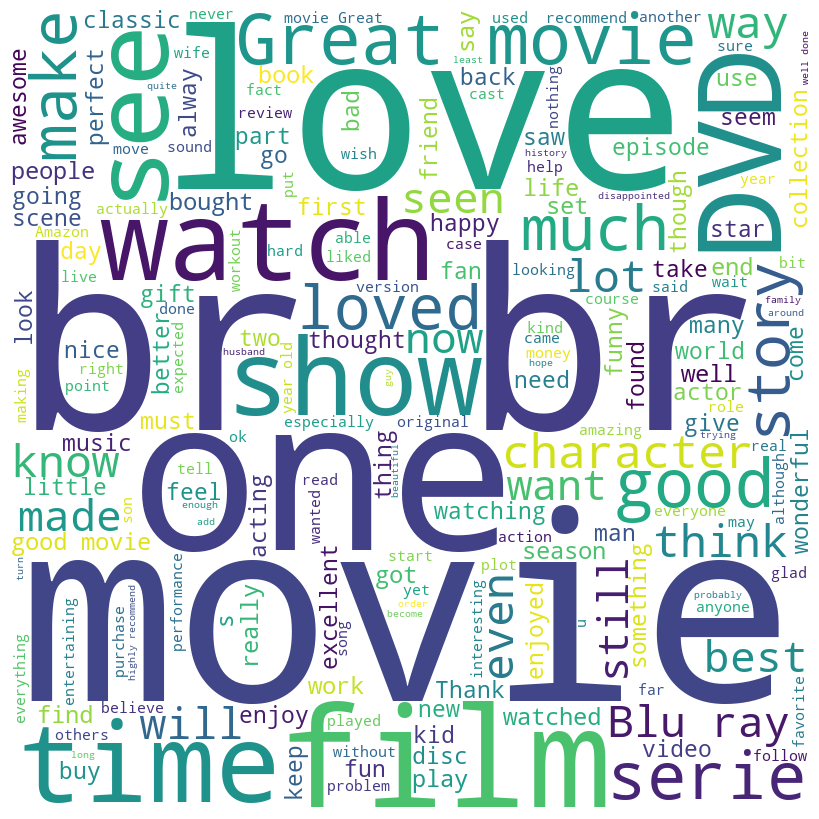

In [6]:
df['review_body']=df['review_body'].astype(str)

# creating word clouds of the most common words used in the reviews.
reviews_text = ' '.join(df['review_body'].dropna().values)
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(reviews_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

creating word clouds of the most common words used in the reviews for movies with rating more than 3

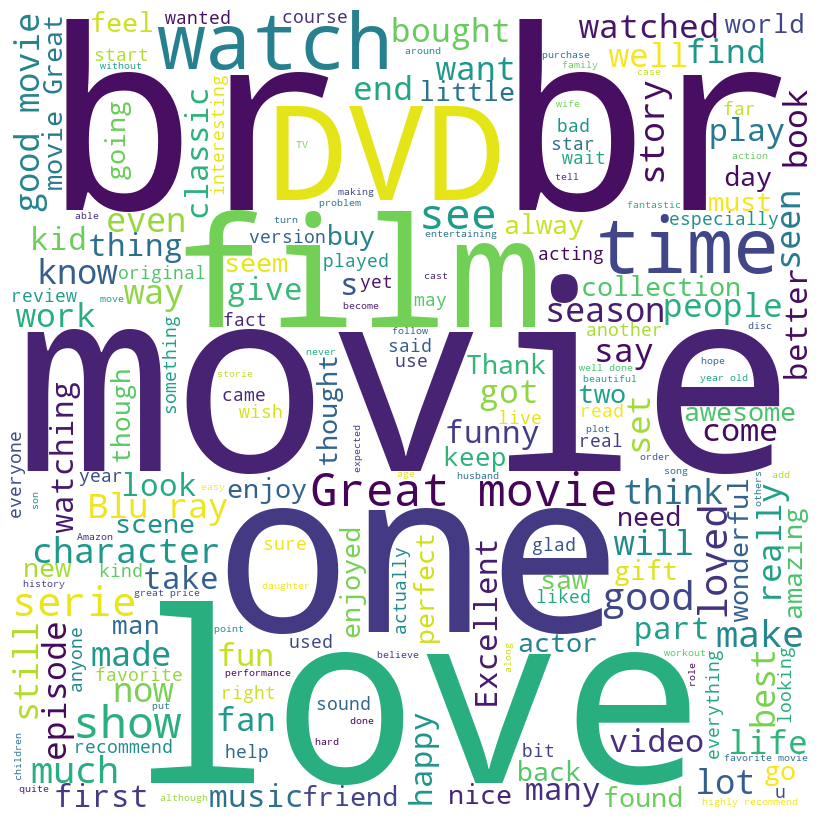

In [104]:

low_rating_df = df[df['star_rating'] > 3.0]
reviews_text = ' '.join(low_rating_df['review_body'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(reviews_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Correlation between features

In [106]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_cols.corr()
correlation_matrix

,customer_id,product_parent,star_rating,helpful_votes,total_votes
customer_id,1.000000,0.001117,-0.029183,0.024062,0.024857
product_parent,0.001117,1.000000,-0.004717,0.000657,0.003662
star_rating,-0.029183,-0.004717,1.000000,-0.056720,-0.133419
helpful_votes,0.024062,0.000657,-0.056720,1.000000,0.916847
total_votes,0.024857,0.003662,-0.133419,0.916847,1.000000


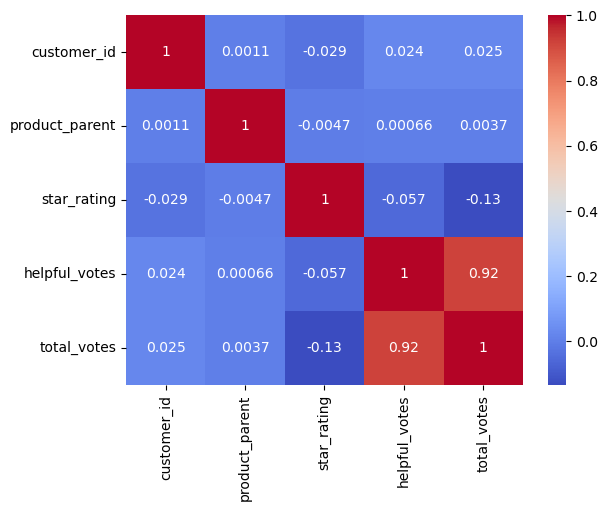

In [108]:
tc = df.corr()
sns.heatmap(tc,annot=True, cmap='coolwarm')
plt.show()

Selecting 4 feature for the recommend system

In [109]:
df_reduced=df[['customer_id', 'product_id', 'star_rating', 'product_title']]
df_reduced=df_reduced[~df_reduced.duplicated()]

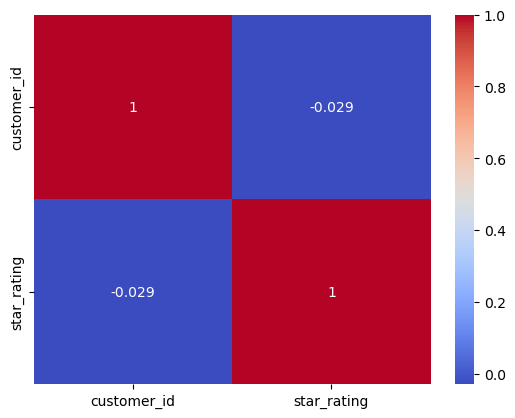

In [110]:
tc = df_reduced.corr()
sns.heatmap(tc,annot=True,cmap='coolwarm')
plt.show()

Visualizing the mean of ratings

In [111]:
rating_movies=df_reduced.groupby('product_id')['star_rating'].mean()
rating_movies.head()

product_id
12175412    5.0
12273848    5.0
17702313    5.0
73378208    1.5
98529455    5.0
Name: star_rating, dtype: float64

<AxesSubplot:xlabel='star_rating', ylabel='Density'>

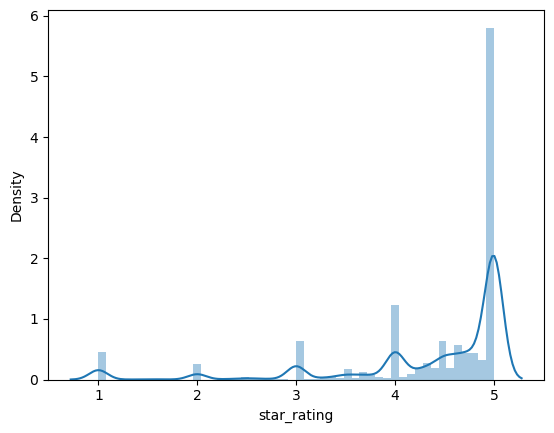

In [112]:
sns.distplot(rating_movies,kde=True)

Visualizing the number of ratings per movie

In [ ]:
movies_rate_count=df_reduced.groupby('product_id')['star_rating'].count()
product_rate_count.head()

<AxesSubplot:xlabel='star_rating', ylabel='Density'>

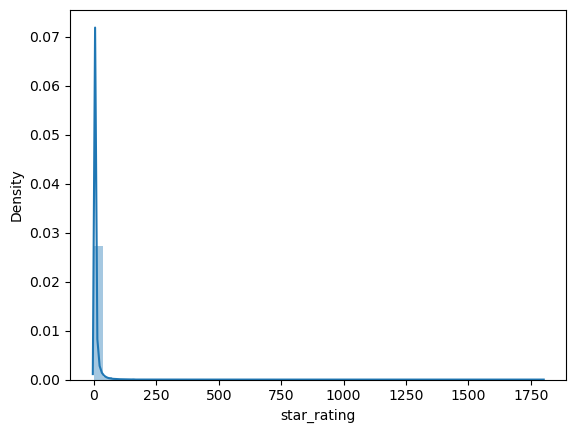

In [114]:
sns.distplot(movies_rate_count,kde=True)

Visualizing the number of ratings by user

In [115]:
user_rate = df_reduced.groupby(by='customer_id')['star_rating'].count().sort_values(ascending=False)
user_rate.head()

customer_id
7080939     563
10905577    387
14283116    377
43430756    370
52868156    368
Name: star_rating, dtype: int64

<AxesSubplot:xlabel='star_rating', ylabel='Density'>

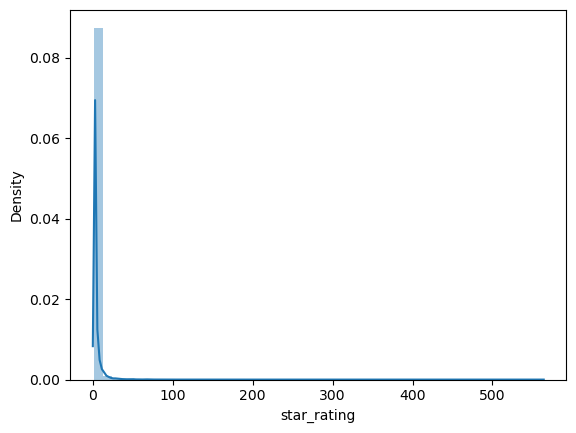

In [116]:
sns.distplot(user_rate, kde=True)

The weighted rating system

The weighted rating system is a method used to calculate a composite rating by taking into account both the average rating of an item and the number of ratings it has received. It aims to provide a more balanced representation of an item's quality by considering both the rating value and the popularity of the item.


Weighted Rating = ( (v / (v + m)) * R ) + ( (m / (v + m)) * C )

Where:

R is the average rating of the item.
v is the number of ratings the item has received.
m is a parameter that represents the minimum number of ratings required to be considered.
C is the mean rating across all items.

In [132]:
rate_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
rate_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = rate_averages.mean()
m = rate_counts.quantile(0.95)
ratings.head()

,star_rating,ratings_count,ratings_average
product_id,,,
12175412,5.0,1,5.0
12273848,5.0,1,5.0
17702313,5.0,1,5.0
73378208,1.5,2,1.5
98529455,5.0,2,5.0


In [ ]:
def weighted_rating(x):
    v = x['ratings_count']
    R = x['ratings_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [148]:
qualified = ratings[(ratings['ratings_count'] >= m) & (ratings['ratings_count'].notnull()) & (ratings['ratings_average'].notnull())][['ratings_count', 'ratings_average']]
qualified['ratings_count'] = qualified['ratings_count'].astype('int')
qualified['ratings_average'] = qualified['ratings_average'].astype('int')


Top movies with weighted rating

In [160]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(30)
pop=qualified.head(30)
pop

,ratings_count,ratings_average,wr
product_id,,,
B00O1D3C2K,40,5,4.710771
B00CL1516E,38,5,4.701130
B00005JKZY,38,5,4.701130
B00026L7RM,37,5,4.696064
B00CQ8792G,35,5,4.685400
B00FR23GPW,34,5,4.679782
B00CQ8792Q,34,5,4.679782
B00GTZWXFU,34,5,4.679782
B008JFUP0I,32,5,4.667922


In [159]:
matching_column = 'product_id'
# Merge the two tables based on the matching column
merged_df = df_reduced.merge(pop, on=matching_column, how='inner')
unique_values = merged_df['product_title'].drop_duplicates()

unique_values

0                    Signed, Sealed, Delivered Christmas
40                                Wee Sing in Sillyville
77                     Perry Mason: Complete Series Pack
115                       Dragons: Riders of Berk Part 2
150                                    Revenge: Season 3
184    Law & Order: Special Victims Unit - The Fiftee...
218                       Dragons: Riders of Berk Part 1
252    Fast & Furious 6 (Steelbook) (Blu-ray + DVD + ...
284        The Lord of the Rings: The Return of the King
322                           The Golden Girls: Season 6
Name: product_title, dtype: object

In [161]:
ratings = pd.DataFrame(rating_movies)
ratings['ratings_count'] = pd.DataFrame(movies_rate_count)
ratings['ratings_average'] = pd.DataFrame(rating_movies)
ratings.head(10)

,star_rating,ratings_count,ratings_average
product_id,,,
12175412,5.0,1,5.0
12273848,5.0,1,5.0
17702313,5.0,1,5.0
73378208,1.5,2,1.5
98529455,5.0,2,5.0
101529376,1.0,1,1.0
307142094,5.0,1,5.0
307142604,5.0,1,5.0
307514161,5.0,1,5.0


Visualizing sum of rating

<AxesSubplot:>

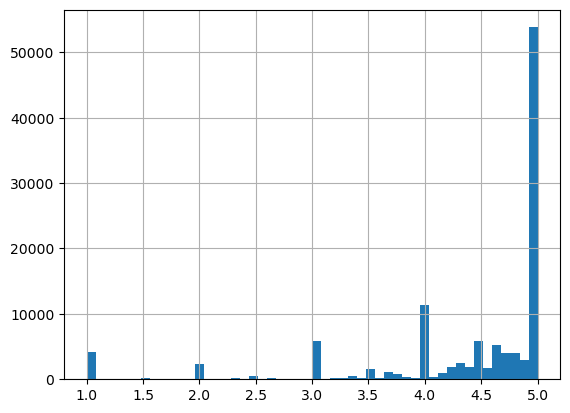

In [162]:
ratings['star_rating'].hist(bins=50)

Movies with the most Rating

<AxesSubplot:xlabel='product_title'>

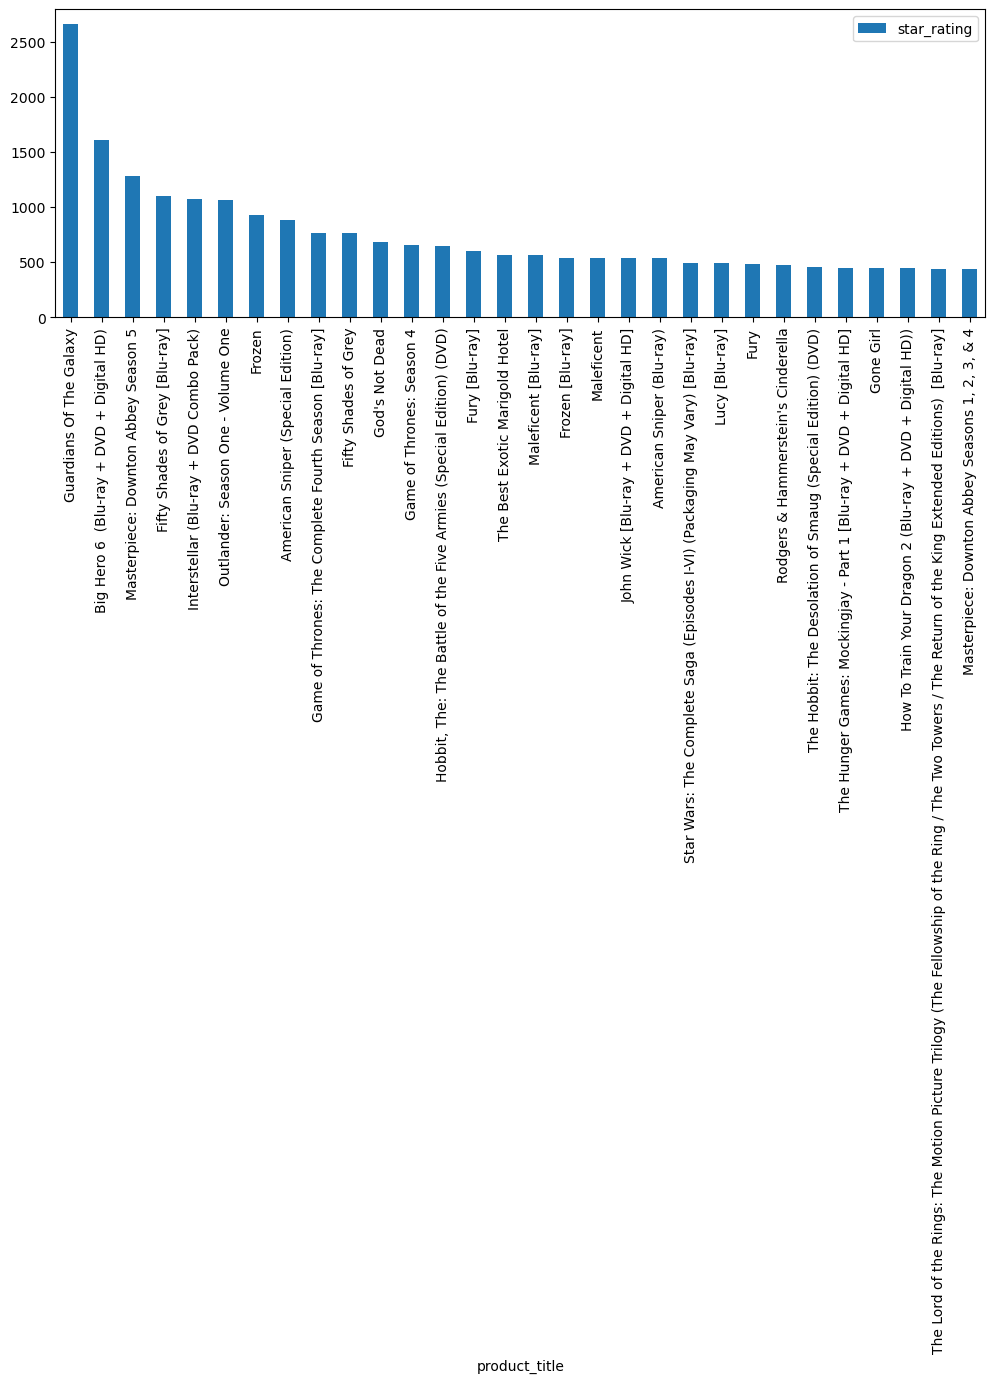

In [163]:
# Most top 30 products
popular_movies = pd.DataFrame(df_reduced.groupby('product_title')['star_rating'].count())
most_popular = popular_movies.sort_values('star_rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

Cross-validation is a technique used in machine learning to assess the performance of a model on unseen data and evaluate its generalization ability. It involves splitting the available data into multiple subsets or "folds" to simulate the model's performance on different test sets

In [167]:
X = df_reduced[['customer_id', 'product_id', 'product_title']]
y = df_reduced['star_rating']
X['customer_id'] = X['customer_id'].astype(str)
X['product_id'] = X['product_id'].astype(str)
X['product_title'] = X['product_title'].astype(str)

label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)
model = LogisticRegression()

# Perform k-fold cross-validation for k=1 to 5
for k in range(2, 6):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_encoded, y, cv=kf)
    f1_scores = cross_val_score(model, X_encoded, y, cv=kf, scoring='f1_macro')
    print(f"Cross-Validation Scores for k={k}:", cv_scores)
    print(f"Average Accuracy for k={k}:", cv_scores.mean())
    print(f"F1 Scores for k={k}:", f1_scores)
    print(f"Average F1 Score for k={k}:", f1_scores.mean())
    print()


Cross-Validation Scores for k=2: [0.76144773 0.76044973]
Average Accuracy for k=2: 0.760948730416502
F1 Scores for k=2: [0.17291407 0.17278533]
Average F1 Score for k=2: 0.17284970015835593

Cross-Validation Scores for k=3: [0.76172898 0.76044421 0.76067301]
Average Accuracy for k=3: 0.7609487311483537
F1 Scores for k=3: [0.17295032 0.17278462 0.17281415]
Average F1 Score for k=3: 0.17284969556099794

Cross-Validation Scores for k=4: [0.76095272 0.76194275 0.76040573 0.76049373]
Average Accuracy for k=4: 0.760948731142509
F1 Scores for k=4: [0.17285023 0.17297787 0.17277965 0.17279101]
Average F1 Score for k=4: 0.1728496912136238

Cross-Validation Scores for k=5: [0.76163029 0.7615203  0.75987592 0.76132789 0.76038924]
Average Accuracy for k=5: 0.7609487293104746
F1 Scores for k=5: [0.1729376  0.17292342 0.17271125 0.17289862 0.17277753]
Average F1 Score for k=5: 0.17284968310351628



Collaberative filtering 

In [169]:
reader=Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_reduced[['customer_id', 'product_id', 'star_rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE', 'MSE', 'fcp'], cv=5, verbose=True)


Evaluating RMSE, MAE, MSE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9197  0.9226  0.9327  0.9244  0.9236  0.9246  0.0043  
MAE (testset)     0.5899  0.5917  0.5960  0.5926  0.5908  0.5922  0.0021  
MSE (testset)     0.8459  0.8512  0.8699  0.8545  0.8530  0.8549  0.0080  
FCP (testset)     0.4975  0.5126  0.5046  0.5079  0.5022  0.5050  0.0051  
Fit time          7.11    7.33    8.00    7.40    7.43    7.46    0.30    
Test time         0.80    0.69    0.77    1.84    0.76    0.97    0.43    


{'test_rmse': array([0.9197456 , 0.9226302 , 0.93268145, 0.92441331, 0.92357519]),
 'test_mae': array([0.58988119, 0.59173104, 0.59601888, 0.59262995, 0.59082552]),
 'test_mse': array([0.84593196, 0.85124649, 0.86989469, 0.85453997, 0.85299113]),
 'test_fcp': array([0.4974857 , 0.51260051, 0.50458184, 0.50793745, 0.50219096]),
 'fit_time': (7.11406397819519,
  7.331974029541016,
  8.004684209823608,
  7.398422002792358,
  7.430698871612549),
 'test_time': (0.7996048927307129,
  0.6901490688323975,
  0.7735939025878906,
  1.837989091873169,
  0.7611782550811768)}

In [29]:
df_reduced.head()

,customer_id,product_id,star_rating,product_title
0,52751110,B0073O0AME,4,Duets II: The Great Performances [Blu-ray]
1,24389524,B0052YAXT2,4,MAXIMILIAN SAINT OF AUSCHWITZ performed by LEO...
2,25230040,B004CRR9IS,5,Jillian Michaels Ripped in 30
3,29608241,B00KTFJ6J2,5,NYPD Blue: Season 7
4,17896413,B000Q66J1M,5,2001: A Space Odyssey [Blu-ray]


In [30]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [31]:
# Check specific userId review
df_reduced[df_reduced['customer_id'] == 24389524]

,customer_id,product_id,star_rating,product_title
1,24389524,B0052YAXT2,4,MAXIMILIAN SAINT OF AUSCHWITZ performed by LEO...


In [35]:
# predict based on this data
svd.predict(24389524, 'B0052YAXT2', 5.0)

Prediction(uid=24389524, iid='B0052YAXT2', r_ui=5.0, est=4.366726976344719, details={'was_impossible': False})

In [33]:
# Check specific userId review
df_reduced[df_reduced['customer_id'] == 29608241]

,customer_id,product_id,star_rating,product_title
3,29608241,B00KTFJ6J2,5,NYPD Blue: Season 7
66,29608241,B00BNAE6M4,5,A Taste of Romance (Hallmark)
115,29608241,B00I458456,5,Mama's Family: Season 4
176,29608241,B00AEFXWXI,5,Failure To Launch
207,29608241,B000UX6TPM,5,The Cosby Show: Season 6
248,29608241,B00D2UMHB0,5,Mama's Family: Season 1
322,29608241,B00LU5PB0I,5,WINGS - The Complete Series
348,29608241,B005S9EJ14,5,The Best Exotic Marigold Hotel
396,29608241,B00116GEES,5,The Cosby Show: Season 8
425,29608241,B0002ZDVEU,5,The Bourne Supremacy (Widescreen Edition)


In [34]:
# predict based on this data
svd.predict(29608241, 'B00KTFJ6J2', 5.0)

Prediction(uid=29608241, iid='B00KTFJ6J2', r_ui=5.0, est=5, details={'was_impossible': False})

Because the size of the data was big and my computer is not able to process data. I got random sample from dataset

In [170]:
df_reduced=df_reduced.sample(n=10000,replace=False)
df_reduced.shape

(10000, 4)

In [171]:
df_reduced.head()

,customer_id,product_id,star_rating,product_title
370764,36893756,B00HUAGZKW,5,Easy Yoga: The Secret to Strength and Balance ...
553825,51090988,B00061QJX0,5,Benny Hill Complete and Unadulterated - The Na...
87775,25586009,B00CZB9BE8,5,Emperor
72192,11823675,B00278FS8M,5,Leslie Sansone: Walk at Home: Walk Your Belly ...
345639,438391,B003UPPO2G,5,Bee Gees: One Night Only


In [172]:
movie_rate = df_reduced.pivot_table(index='customer_id', columns='product_title', values='star_rating')
movie_rate.fillna(0, inplace=True)

In [173]:
movie_rate.head()

product_title,2012,2046,#SorryNotSorry with Jenna Kim Jones,(2-Disc DVD with benefits) Zatoichi THE LAST <Blu-ray> Deluxe Edition [Blu-ray],(Double Feature) Semi-Tough / Gator,*Batteries Not Included,"1,000 Times Good Night",10 Min Sol:rapid Results Pilat,10 Minute Solution: 5 Day Get Fix Mix,10 Minute Solution: Butt Lift,...,Zumba Fitness 30 Minute Burn+Amazing Abs DVD From The Incredible Results Set!,Zumba Fitness Quick Start+20 Minute Express DVD From The Incredible Results Set!,Zumba Fitness Step by Step DVD from the Exhilarate DVD set,death smiles at murder,"iCarly: Season 1, Vol. 1",iCarly: iSpace Out,"once upon a time in high school (Korean Movie, English Sub, All Zone DVD)",una pura formalita' / A Pure Formality (Dvd) Italian Import,"untitled[NON-US FORMAT, PAL]","¡Bienvenido, Míster Marshall! (1953) (Import Movie) (European Format - Zone 2)"
customer_id,,,,,,,,,,,,,,,,,,,,,
10293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
ratings =pd.DataFrame(df_reduced.groupby('product_title')['star_rating'].mean())
ratings['rating_numbers'] = pd.DataFrame(df.groupby('product_title')['star_rating'].count())


Content base recommendation

In [182]:
def recommend_movies(name , min_rate_no = 10):
    user_rating = movie_rate[name]
    similar_movies = movie_rate.corrwith(user_rating)
    corr_movies = pd.DataFrame(similar_movies, columns=['Correlation'])
    corr_movies.dropna(inplace=True)
    corr_movies = corr_movies.join(ratings['rating_numbers'], how='left', lsuffix='_left', rsuffix='_right')
    
    final = corr_movies[corr_movies['rating_numbers']>min_rate_no].sort_values('Correlation', ascending=False)
    return final

In [183]:
# Get recommendation for special movie
recommendations = recommend_movies('The Blind Side')
recommendations.head(n=10)

,Correlation,rating_numbers
product_title,,
The Blind Side,1.000000,151
Strictly Business,-0.000151,29
Look Who's Talking/Look Who's Talking Too,-0.000151,17
Baseball: A Film by Ken Burns (Includes The Tenth Inning),-0.000151,58
Perry Mason Mysteries: The Original Warner Bros. Movies Collection,-0.000151,15
The Abominable Dr. Phibes / Dr. Phibes Rises Again! (Midnite Movies Double Feature),-0.000151,16
Mind Meld - Secrets Behind the Voyage of a Lifetime,-0.000151,11
Mighty Machines: Making Tracks,-0.000151,11
"To Sir, With Love",-0.000151,49


In [184]:
# Get recommendation for special movie
recommendations = recommend_movies('Emperor')
recommendations.head(n=10)

,Correlation,rating_numbers
product_title,,
Emperor,1.000000,16
Strictly Business,-0.000107,29
The Abominable Dr. Phibes / Dr. Phibes Rises Again! (Midnite Movies Double Feature),-0.000107,16
Baseball: A Film by Ken Burns (Includes The Tenth Inning),-0.000107,58
Look Who's Talking/Look Who's Talking Too,-0.000107,17
Perry Mason Mysteries: The Original Warner Bros. Movies Collection,-0.000107,15
The Hills: Season 4,-0.000107,11
"American Pie 1, 2, 3 & Reunion [Blu-ray]",-0.000107,13
The Monkees: Season 2,-0.000107,17
